# Introduction

In [1]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from ipywidgets import *
from datetime import datetime
from IPython.display import Image
from matplotlib.dates import DateFormatter

In [2]:
DATA_PATH = 'data/'
BTC_PATH = DATA_PATH + 'bitcoin/'
ETH_PATH = DATA_PATH + 'ethereum/'
HARDWARE_PATH = DATA_PATH+'hardware/'

In [3]:
seconds_in_year = 31536000
hours_in_year = 8760
seconds_in_day = 86400
kWh_to_J = 3600*10**3
W_to_TWh = hours_in_year/(10**12)

std_PUE = {'lower': 1, 'estimate': 1.1, 'upper':1.2}
revenue_percent = 0.60

BTC_block_time = 600
BTC_difficulty_factor = 2**32

ETH_block_time = 15
ETH_difficulty_factor = 1


# Plots
date_form = DateFormatter("%m-%d")

In [4]:
def hashrate_from_difficulty(difficulty):
    return difficulty*difficulty_factor/BTC_block_time

## Geography 

In [5]:
# US: https://www.statista.com/statistics/190680/us-industrial-consumer-price-estimates-for-retail-electricity-since-1970/
# China: https://www.mondaq.com/china/oil-gas-electricity/804336/china-electricity-prices-for-industrial-consumers
# Russia: https://www.mondaq.com/china/oil-gas-electricity/804336/china-electricity-prices-for-industrial-consumers
# Kazakhstan: https://www.globalpetrolprices.com/Kazakhstan/electricity_prices/
# Malaysia: https://www.globalpetrolprices.com/Malaysia/electricity_prices/
# Iran: https://financialtribune.com/articles/energy/97278/rise-in-electricity-and-water-tariffs-in-iran

In [6]:
data = {'location': ['China', 'US', 'Russia', 'Kazakhstan', 'Malaysia','Iran','Canada','Norway','Germany'],
        'share': [66.17, 7.15, 6.43, 5.89, 4.22, 3.67, 0.80, 0.67, 0.5],
        'normal_price': [0.074, 0.0693, 0.041, 0.046, 0.101, 0.07, 0.10, 0.08, 0.2]}
CBECI_geography = pd.DataFrame(data).set_index('location')
CBECI_geography['share'] = CBECI_geography['share']/100 
CBECI_geography['normal_price'] = CBECI_geography['normal_price']/kWh_to_J
CBECI_geography.loc['RoW'] = [1-np.sum(CBECI_geography['share']), 0.084/kWh_to_J]
CBECI_geography

,share,normal_price
location,,
China,0.6617,2.055556e-08
US,0.0715,1.925000e-08
Russia,0.0643,1.138889e-08
Kazakhstan,0.0589,1.277778e-08
Malaysia,0.0422,2.805556e-08
Iran,0.0367,1.944444e-08
Canada,0.0080,2.777778e-08
Norway,0.0067,2.222222e-08
Germany,0.0050,5.555556e-08


In [7]:
avg_elec_price = np.sum(CBECI_geography.share*CBECI_geography.normal_price)
avg_geography = pd.DataFrame({'share':1, 'normal_price':avg_elec_price}, index=['world'])
avg_geography

,share,normal_price
world,1,2.005935e-08


In [8]:
china_data = {'location': ['Xinjiang', 'Sichuan', 'Nei Mongol', 'Yunnan', 'Beijing', 'Zhejiang', 'Shanxi', 'Gansu', 'Guizhou', 'Qinhai'],
             'share': [36.49,9.74,8.22,5.5,1.5,0.82,0.71,0.57,0.28,0.26]}
#CBECI_geography_china = CBECI_geography.append(pd.DataFrame(china_data)).set_index('location').drop('China').sort_values(by='share', ascending=False)

## Functions

In [9]:
def calc_profitability_threshold(data, PUE, elec_price, growth_factor):
    rev_per_hash = data['revenue']*growth_factor/data['hashrate'] #$/h
    return rev_per_hash/(elec_price*PUE)

def is_profitable(hardware, data, PUE, elec_price, growth_factor=1):
    profitability_threshold = calc_profitability_threshold(data, PUE, elec_price, growth_factor)
    # consumption is J/h, if smaller, more efficient
    if hardware['consumption'] < profitability_threshold:
        return True
    else:
        return False
    
def get_profitable_hardware(data, hardware, PUE_dict = std_PUE, bound = 'estimate', PUE_fix = True, elec_price = avg_elec_price, growth_factor = 1):
    if bound == "lower":
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['lower'], elec_price),axis=1)]
    elif bound == "upper":
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['upper'], elec_price),axis=1)]
    else:
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['estimate'], elec_price),axis=1)]
    if prof_hardware.empty and PUE_fix:
        prof_hardware = hardware[hardware.consumption == hardware.consumption.min()]
    return prof_hardware

In [10]:
def get_buy_hardware(hardware):
    return hardware.sort_values(by='consumption').iloc[0]

def get_turn_on_hardware(hardware):
    return hardware.sort_values(by='consumption').iloc[0]

def get_turn_off_hardware(hardware): 
    return hardware.sort_values(by='consumption', ascending=False).iloc[0]

In [11]:
def calc_consumption(hardware):
    # TODO: bounds
    return np.sum(hardware['on_num']*hardware['hashing_power']*hardware['consumption'])

In [12]:
def replace_hardware(time, data, hardware):
    # If hardware not profitable with double bitcoin price, replace!
    to_replace = hardware[~hardware.apply(lambda x: is_profitable(x, data, std_PUE['estimate'], avg_elec_price, growth_factor = 2), axis=1)]  
    to_replace = to_replace[to_replace['on_num'] >= 1]
    
    if to_replace.empty:
        return hardware
    
    replace_hashrate = np.sum(to_replace['on_num']*to_replace['hashing_power'])
        
    cur_hardware = hardware[hardware.release_date < time]
    prof_hardware = get_profitable_hardware(data, cur_hardware)

    best_hardware = get_next_hardware(prof_hardware)
    
    #print(best_hardware)
        
    hardware.loc[to_replace.index, 'off_num'] += hardware.loc[to_replace.index, 'on_num']
    hardware.loc[to_replace.index, 'on_num'] = 0

    num_extra = np.ceil(replace_hashrate/best_hardware.hashing_power)
    hardware.loc[best_hardware.name, 'on_num'] += num_extra

    return hardware

# Bitcoin

## Loading history

In [24]:
difficulty = pd.read_csv(BTC_PATH+'difficulty.csv')
revenue = pd.read_csv(BTC_PATH+'miners-revenue.csv')
price = pd.read_csv(BTC_PATH+'price.csv')

difficulty['Timestamp'] = pd.to_datetime(difficulty['Timestamp'])
revenue['Timestamp'] = pd.to_datetime(revenue['Timestamp'])
price['Timestamp'] = pd.to_datetime(price['Timestamp'])

difficulty = difficulty.rename(columns={'Timestamp': 'timestamp'}).set_index('timestamp')
revenue = revenue.rename(columns={'Timestamp': 'timestamp', 'miners-revenue': 'revenue'}).set_index('timestamp')
price = price.rename(columns={'Timestamp': 'timestamp', 'market-price': 'price'}).set_index('timestamp')

In [14]:
revenue = revenue.groupby(pd.Grouper(freq='W')).mean()
revenue = revenue/seconds_in_day
difficulty = difficulty.groupby(pd.Grouper(freq='W')).mean()
bitcoin = difficulty.join(revenue).dropna()

In [26]:
price = price.groupby(pd.Grouper(freq='W')).mean()
price = bitcoin.join(price)
price

,difficulty,revenue,price
timestamp,,,
2009-01-25,1.000000e+00,0.000000,0.000000
2009-02-01,1.000000e+00,0.000000,0.000000
2009-02-08,1.000000e+00,0.000000,0.000000
2009-02-15,1.000000e+00,0.000000,0.000000
2009-02-22,1.000000e+00,0.000000,0.000000
...,...,...,...
2020-04-12,1.431387e+13,157.268844,7039.395000
2020-04-19,1.471521e+13,164.153155,6984.965000
2020-04-26,1.595865e+13,155.823463,7270.183333


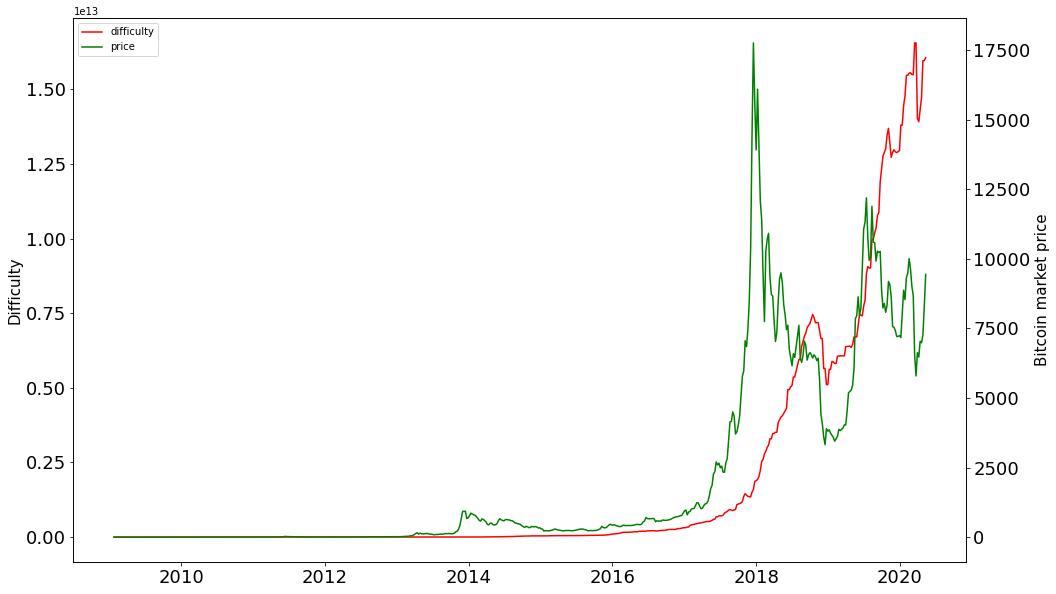

In [63]:
fig, ax1 = plt.subplots(figsize=(16,10))

ln1 = ax1.plot(bitcoin['difficulty'],color="red", label="difficulty")

ax2 = ax1.twinx()

ln2 = ax2.plot(price['price'], color="green", label="price")

# added these three lines
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

#ax2.legend(loc='upper left')

ax1.set_ylabel('Difficulty', fontsize = 15)
ax2.set_ylabel('Bitcoin market price', fontsize = 15)

ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

plt.show()

In [75]:
first_halve = datetime(2012, 11, 1)
second_halve = datetime(2016, 7, 1)
third_halve = datetime(2020, 5, 13)

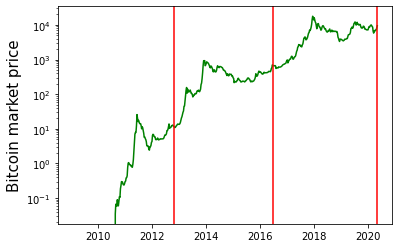

In [76]:
plt.plot(price['price'], color="green", label="price")
#plt.plot(first_halve)

plt.axvline(first_halve, color='red')
plt.axvline(second_halve, color='red')
plt.axvline(third_halve, color='red')


plt.yscale('log')

plt.ylabel('Bitcoin market price', fontsize = 15)
plt.show()

In [558]:
import matplotlib.dates as mdates

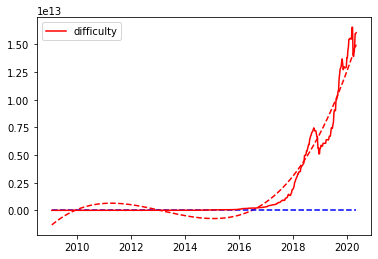

In [561]:
x = mdates.date2num(bitcoin.index)
z = np.polyfit(x,bitcoin['difficulty'], 3)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

z2 = np.polyfit(x,np.log(bitcoin['difficulty']), 1)
p2 = np.poly1d(z2)
plt.plot(x,p2(x),"b--")

plt.plot(bitcoin['difficulty'],color="red", label="difficulty")
plt.legend()
plt.show()

C:\Users\Admin\Anaconda3\envs\thesis\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


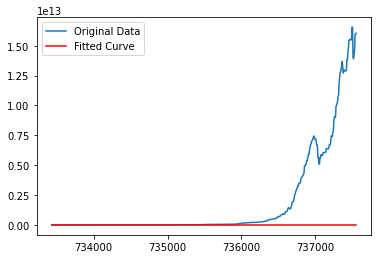

In [562]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = mdates.date2num(bitcoin.index)

popt, pcov = curve_fit(func, x, bitcoin['difficulty'])

plt.figure()
plt.plot(x, bitcoin['difficulty'], label="Original Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [518]:
z

array([ 2.73129899e+03, -6.02828265e+09,  4.43503118e+15, -1.08762318e+21])

In [ ]:
xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)

cx.plot(dd, p4(xx), '-g')
cx.plot(dates, y, '+', color='b', label='blub')


In [564]:
SHA256_hardware = pd.read_csv(HARDWARE_PATH+'SHA256_hardware_clean.csv',index_col=0)
# Initialisation
hardware = SHA256_hardware[['name', 'release_date', 'consumption', 'hashing_power']].copy()
hardware['release_date'] = pd.to_datetime(hardware['release_date'])
hardware

,name,release_date,consumption,hashing_power
0,Bitmain Antminer S3,2014-07-01,7.660000e-10,4.780000e+11
1,Bitmain Antminer S5,2014-12-01,5.110000e-10,1.000000e+12
2,Bitmain Antminer S7,2015-09-01,2.730000e-10,5.000000e+12
3,Bitmain Antminer S9 (11.5Th),2016-06-01,9.800000e-11,1.200000e+13
4,Bitmain Antminer S7-LN,2016-06-01,2.580000e-10,3.000000e+12
...,...,...,...,...
74,Canaan AvalonMiner 1047,2019-09-01,6.430000e-11,3.700000e+13
75,Bitmain Antminer S17e,2019-11-01,4.500000e-11,6.400000e+13
76,Bitmain Antminer T17e,2019-11-01,5.500000e-11,5.300000e+13
77,Bitmain Antminer S17+,2019-12-01,4.000000e-11,7.300000e+13


In [565]:
hardware.sort_values(by='consumption')

,name,release_date,consumption,hashing_power
56,Bitmain Antminer S17 Pro (53Th),2019-04-01,3.950000e-11,5.300000e+13
57,Bitmain Antminer S17 Pro (50Th),2019-04-01,3.950000e-11,5.000000e+13
77,Bitmain Antminer S17+,2019-12-01,4.000000e-11,7.300000e+13
60,Innosilicon T3+ 52T,2019-05-01,4.230000e-11,5.200000e+13
75,Bitmain Antminer S17e,2019-11-01,4.500000e-11,6.400000e+13
...,...,...,...,...
22,Bitmain Antminer V9 (4Th),2018-03-01,2.570000e-10,4.000000e+12
4,Bitmain Antminer S7-LN,2016-06-01,2.580000e-10,3.000000e+12
2,Bitmain Antminer S7,2015-09-01,2.730000e-10,5.000000e+12
1,Bitmain Antminer S5,2014-12-01,5.110000e-10,1.000000e+12


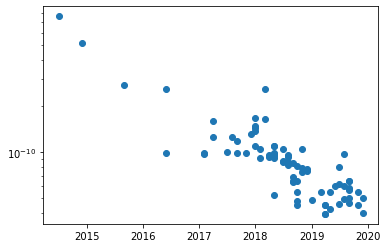

In [566]:
plt.scatter(hardware['release_date'], hardware['consumption'])
plt.yscale('log')
plt.show()

In [567]:
# Select only from first hardware available in dataset
bitcoin = bitcoin[bitcoin.index > SHA256_hardware.loc[0,'release_date']]

# Difficulty to hashrate
bitcoin['hashrate'] = bitcoin['difficulty'].apply(lambda x: hashrate_from_difficulty(x))

In [573]:
hardware['off_num'] = 0
hardware['on_num'] = 0

cur_hashrate = 0
consumption = []
for time, data in bitcoin.iterrows():
    cur_hardware = hardware[hardware.release_date < time]
    hashrate_difference = data.hashrate - cur_hashrate
    if hashrate_difference > 0:
        # Network hashrate has increased, turn on/buy devices
        prof_hardware = get_profitable_hardware(data, cur_hardware)
        off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
                
        while cur_hashrate < data.hashrate and (not off_hardware.empty):
            
            best_off_hardware = get_turn_on_hardware(off_hardware)
            
            # Everything gets turned on OR the part needed for hashrate difference gets turned on
            extra_hashing_power = min(best_off_hardware.off_num*best_off_hardware.hashing_power, hashrate_difference)
            
            num_to_on = extra_hashing_power/best_off_hardware.hashing_power
            
            hardware.loc[best_off_hardware.name, 'on_num'] += num_to_on
            hardware.loc[best_off_hardware.name, 'off_num'] -= num_to_on
            
            cur_hashrate += extra_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
            
        if off_hardware.empty and cur_hashrate < data.hashrate:
            # Have to buy new hardware. Buy entire difference in hashrate from get_next_hardware
            best_hardware = get_next_hardware(prof_hardware)
            
            num_extra = np.ceil(hashrate_difference/best_hardware.hashing_power)
            
            hardware.loc[best_hardware.name, 'on_num'] += num_extra
            
            cur_hashrate += num_extra*best_hardware.hashing_power
                
    elif hashrate_difference < 0:
        # Network hashrate has decreased, turn off devices
        on_hardware = hardware[hardware['on_num'] >= 1]
        while cur_hashrate > data.hashrate:            
            worst_on_hardware = get_turn_off_hardware(on_hardware)
        
            min_hashing_power = min(worst_on_hardware.on_num*worst_on_hardware.hashing_power, -hashrate_difference)
            
            num_to_off = np.floor(min_hashing_power/worst_on_hardware.hashing_power)
            
            hardware.loc[worst_on_hardware.name, 'on_num'] -= num_to_off
            hardware.loc[worst_on_hardware.name, 'off_num'] += num_to_off
            
            cur_hashrate -= min_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            on_hardware = prof_hardware[prof_hardware['on_num'] >= 1]
    else:
        #print('hashrate_difference = 0')
        pass
    #hardware = replace_hardware(time, data, hardware)
    cur_hashrate = np.sum(hardware['on_num']*hardware['hashing_power'])
    consumption.append(calc_consumption(hardware)*W_to_TWh)  

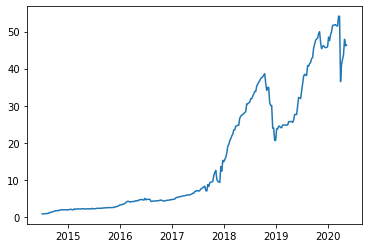

In [574]:
plt.plot(bitcoin.index,consumption)
plt.show()

In [575]:
hardware[(hardware['on_num'] > 0) | (hardware['off_num'] > 0)]

,name,release_date,consumption,hashing_power,off_num,on_num
0,Bitmain Antminer S3,2014-07-01,7.660000e-10,4.780000e+11,603513.0,2.328306e-10
1,Bitmain Antminer S5,2014-12-01,5.110000e-10,1.000000e+12,99905.0,0.000000e+00
2,Bitmain Antminer S7,2015-09-01,2.730000e-10,5.000000e+12,212535.0,0.000000e+00
3,Bitmain Antminer S9 (11.5Th),2016-06-01,9.800000e-11,1.200000e+13,126722.0,0.000000e+00
5,Bitmain Antminer R4,2017-02-01,9.710000e-11,9.000000e+12,1683537.0,2.328306e-10
20,Ebang Ebit E10,2018-02-01,9.170000e-11,1.800000e+13,123809.0,4.324930e+05
26,ASICminer 8 Nano Pro,2018-05-01,5.260000e-11,7.600000e+13,0.0,3.034700e+05
44,Ebang Ebit E11++,2018-10-01,4.500000e-11,4.400000e+13,0.0,1.846990e+05
56,Bitmain Antminer S17 Pro (53Th),2019-04-01,3.950000e-11,5.300000e+13,0.0,9.218320e+05
57,Bitmain Antminer S17 Pro (50Th),2019-04-01,3.950000e-11,5.000000e+13,0.0,5.420310e+05


In [483]:
(hardware.loc[56, 'on_num'] + hardware.loc[57, 'on_num']) / np.sum(hardware['on_num'])

0.7837534571848889

In [484]:
bitcoin.iloc[len(bitcoin)-1]

difficulty    1.605609e+13
revenue       2.055335e+02
hashrate      1.149340e+20
Name: 2020-05-10 00:00:00, dtype: float64

In [485]:
np.sum(hardware['on_num']*hardware['hashing_power'])

1.149339626427349e+20

# Ethereum

In [488]:
difficulty = pd.read_csv(ETH_PATH+'difficulty.csv')
reward = pd.read_csv(ETH_PATH+'reward.csv')
price = pd.read_csv(ETH_PATH+'price.csv')

difficulty = difficulty.drop(columns='UnixTimeStamp')
difficulty.columns = ['date', 'value']
reward.columns = ['date', 'reward']
price.columns = ['date', 'price']

In [489]:
for data in [difficulty, reward, price]:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

In [490]:
difficulty = difficulty.groupby(pd.Grouper(freq='W')).mean()*10**12 # difficulty given in T per block
reward = reward.groupby(pd.Grouper(freq='W')).mean()
price = price.groupby(pd.Grouper(freq='W')).mean()
revenue = reward.join(price)
revenue['revenue'] = revenue['reward']*revenue['price']/seconds_in_day
revenue = revenue[['revenue']]

ethereum = revenue.join(difficulty)
ethereum.columns = ['revenue', 'difficulty']

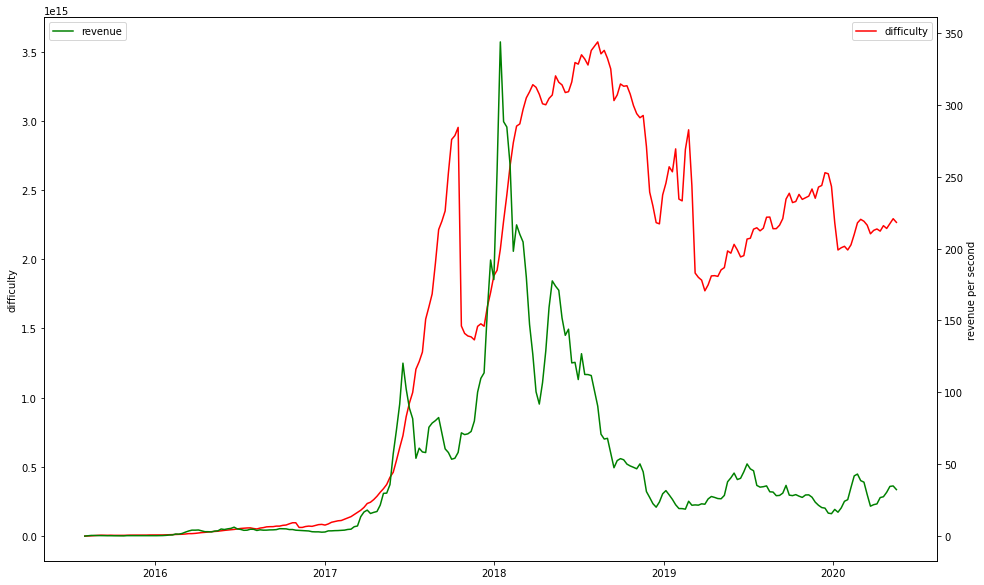

In [491]:
fig, ax1 = plt.subplots(figsize=(16,10))
ax1.plot(ethereum['difficulty'],color="red", label="difficulty")
ax1.legend()
ax1.set_ylabel('difficulty')
ax2 = ax1.twinx()
ax2.plot(ethereum['revenue'], color="green", label="revenue")
ax2.legend(loc='upper left')
ax2.set_ylabel('revenue per second')
plt.show()

In [492]:
ethash_hardware = pd.read_csv(HARDWARE_PATH+'Ethash_hardware_clean.csv',index_col=0)
# Initialisation
hardware = ethash_hardware[['name', 'release_date', 'consumption', 'hashing_power']].copy()
hardware['release_date'] = pd.to_datetime(hardware['release_date'])
hardware[:4]

,name,release_date,consumption,hashing_power
0,Radeon HD 7870,2012-03-19,0.000017,10000000
1,GeForce GTX 680,2012-03-22,0.000013,15000000
2,GeForce GTX 660 Ti,2012-08-16,0.000013,12000000
3,GeForce GTX 650 Ti,2012-09-10,0.000011,10000000


In [493]:
# Select only from first hardware available in dataset
ethereum = ethereum[ethereum.index > ethash_hardware.loc[0,'release_date']]

# Difficulty to hashrate
ethereum['hashrate'] = ethereum['difficulty']*1/ETH_block_time

In [494]:
hardware['off_num'] = 0
hardware['on_num'] = 0

cur_hashrate = 0
consumption = []
for time, data in ethereum.iterrows():
    cur_hardware = hardware[hardware.release_date < time]
    hashrate_difference = data.hashrate - cur_hashrate
    if hashrate_difference > 0:
        # Network hashrate has increased, turn on/buy devices
        prof_hardware = get_profitable_hardware(data, cur_hardware)
        off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
                
        while cur_hashrate < data.hashrate and (not off_hardware.empty):
            
            best_off_hardware = get_turn_on_hardware(off_hardware)
            
            # Everything gets turned on OR the part needed for hashrate difference gets turned on
            extra_hashing_power = min(best_off_hardware.off_num*best_off_hardware.hashing_power, hashrate_difference)
            
            num_to_on = extra_hashing_power/best_off_hardware.hashing_power
            
            hardware.loc[best_off_hardware.name, 'on_num'] += num_to_on
            hardware.loc[best_off_hardware.name, 'off_num'] -= num_to_on
            
            cur_hashrate += extra_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
            
        if off_hardware.empty and cur_hashrate < data.hashrate:
            # Have to buy new hardware. Buy entire difference in hashrate from get_next_hardware
            best_hardware = get_next_hardware(prof_hardware)
            
            num_extra = np.ceil(hashrate_difference/best_hardware.hashing_power)
            
            hardware.loc[best_hardware.name, 'on_num'] += num_extra
            
            cur_hashrate += num_extra*best_hardware.hashing_power
                
    elif hashrate_difference < 0:
        # Network hashrate has decreased, turn off devices
        on_hardware = hardware[hardware['on_num'] >= 1]
        while cur_hashrate > data.hashrate:            
            worst_on_hardware = get_turn_off_hardware(on_hardware)
        
            min_hashing_power = min(worst_on_hardware.on_num*worst_on_hardware.hashing_power, -hashrate_difference)
            
            num_to_off = np.floor(min_hashing_power/worst_on_hardware.hashing_power)
            
            hardware.loc[worst_on_hardware.name, 'on_num'] -= num_to_off
            hardware.loc[worst_on_hardware.name, 'off_num'] += num_to_off
            
            cur_hashrate -= min_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            on_hardware = prof_hardware[prof_hardware['on_num'] >= 1]
    else:
        #print('hashrate_difference = 0')
        pass
    hardware = replace_hardware(time, data, hardware)
    cur_hashrate = np.sum(hardware['on_num']*hardware['hashing_power'])
    consumption.append(calc_consumption(hardware)*W_to_TWh)  

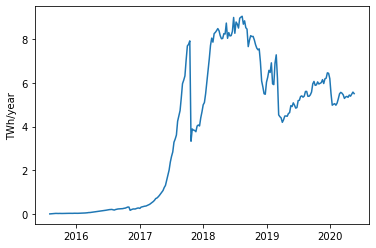

In [504]:
plt.plot(ethereum.index,consumption)
plt.ylabel('TWh/year')
plt.show()

In [505]:
hardware[(hardware['on_num'] > 0) | (hardware['off_num'] > 0)]

,name,release_date,consumption,hashing_power,off_num,on_num
17,GeForce GTX Titan X,2015-03-17,0.000006,40000000,1.493700e+04,0.000000e+00
27,Radeon Rx 480,2016-01-06,0.000006,25000000,1.361640e+05,0.000000e+00
31,GeForce GTX 1060,2016-08-18,0.000005,24000000,1.475207e+05,3.115079e-01
32,Radeon GTX 1050 Ti,2016-10-25,0.000005,15000000,2.420000e+02,0.000000e+00
37,Radeon RX 550,2017-04-20,0.000005,11000000,6.297082e+06,9.993606e+06
42,GeForce GTX 1070 Ti,2017-02-11,0.000005,32000000,3.145870e+05,0.000000e+00
43,GTX Titan V,2017-12-13,0.000003,77000000,0.000000e+00,5.344450e+05


In [497]:
ethereum.iloc[len(ethereum)-1]

revenue       3.235190e+01
difficulty    2.266229e+15
hashrate      1.510819e+14
Name: 2020-05-17 00:00:00, dtype: float64

In [498]:
np.sum(hardware['on_num']*hardware['hashing_power'])

151081939999999.97

In [499]:
ethereum.loc['2020-05-17']

revenue       3.235190e+01
difficulty    2.266229e+15
hashrate      1.510819e+14
Name: 2020-05-17 00:00:00, dtype: float64